# Computational modeling : MLE fitting for various RL agents

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?

In notebook 104, we derived a way to compute the log likelihood of some observed data under families of parametric models. Let's now optimize these parameters to try and explain the observed dynamics ! 


In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import optax

from functools import partial

# 2/ The Active Inference package 
import actynf
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.layer_trial import compute_step_posteriors
from actynf.jaxtynf.layer_learn import learn_after_trial
from actynf.jaxtynf.layer_options import get_learning_options,get_planning_options
from actynf.jaxtynf.shape_tools import to_log_space,get_vectorized_novelty

from actynf.jaxtynf.layer_process import initial_state_and_obs,process_update
from actynf.jaxtynf.shape_tools import vectorize_weights


# 3/ Tools for : 
# a. Getting the raw data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
# b. Preprocessing the data :
from analysis_tools.preprocess import OPTIONS_PREPROCESS_DEFAULT,get_preprocessed_data

# The environment is statically defined by its HMM matrices : 
from simulate.hmm_weights import behavioural_process
from simulate.hmm_weights import basic_latent_model  # Weights for the active inference model : 

# To generate synthetic data :
from simulate.generate_observations import TrainingEnvironment,run_loop,generate_synthetic_data
# To fit the models :
from simulate.compute_likelihood import compute_loglikelihood,fit
from simulate.compute_likelihood import fit_mle_agent

from agents import random_agent,choice_kernel_agent,rescorla_wagner_agent,rw_ck_agent,q_learning_agent,active_inference_basic_1D


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


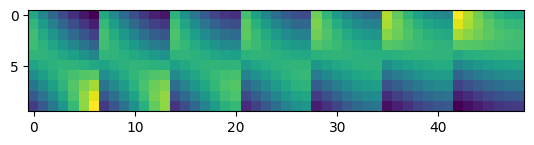

In [2]:
# The virtual environment  ENVIRONMENTAL CONSTANTS :
T = 11
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.5
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)
rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

plt.imshow(a[0])

Let's generate some synthetic data :

We need to define a loss function that takes a vector of parameters and observations as inputs, and returns some kind of cost ! Thankfully, we can use the negative log likelihood as that cost ! The main question is : how to treat the hyperparameters of each model ? 
We need to encode them so that they don't fall off the parameter space ! We thus perofrm gradient descent on a feature vector or real numbers encoding these parameters. For each model, we must thus define an encoder function for each of the models proposed ...

For each agent, we may now simulate a training depending on a set of parameters, as well as invert training data to fit these models. The next step is to perform parameter recovery checks to figure out if the behaviour of these agents allows us to efficiently retrieve these parameters :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


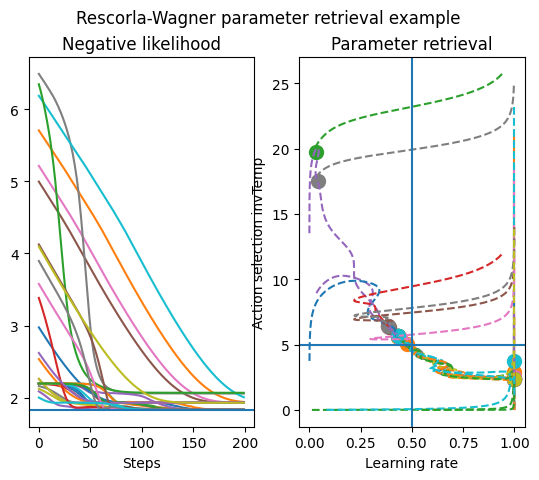

In [6]:

TRUE_PARAMS = (0.5,5.0)
N_TRIALS = 10

static_params = (9,)
rw_agent = partial(rescorla_wagner_agent,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,rw_agent(TRUE_PARAMS),N_TRIALS,10)

# Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,rw_agent,2,jr.PRNGKey(5),true_hyperparams=TRUE_PARAMS,                          
                                                        num_steps=200,n_iter=30,initial_window=[-10,30])

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,2)
axs[0].set_title("Negative likelihood")
axs[0].set_xlabel("Steps")
axs[1].set_title("Parameter retrieval")
axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Action selection invTemp")
fig.suptitle("Rescorla-Wagner parameter retrieval example")
for i,vec in enumerate(opt_vectors):
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses)
    
    # print(encoding_function(vec),loss_history[-1,i])
    lrs,action_selection_temp = vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(lrs,action_selection_temp,linestyle="--")
    axs[1].scatter(lrs[-1],action_selection_temp[-1],s=100)

# Plot true values :
axs[0].axhline(gt_mle)
axs[1].axvline(TRUE_PARAMS[0])
axs[1].axhline(TRUE_PARAMS[1])

Very encouraging ! This model seems to converge pretty well but we can notice that the solution is not a single point but rather a curve on the parameter space : we can explain these results by a set of (action selection temperatures, learning rates). 

The shape of the curve is of course affected by parameters such as the action selection temperature :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


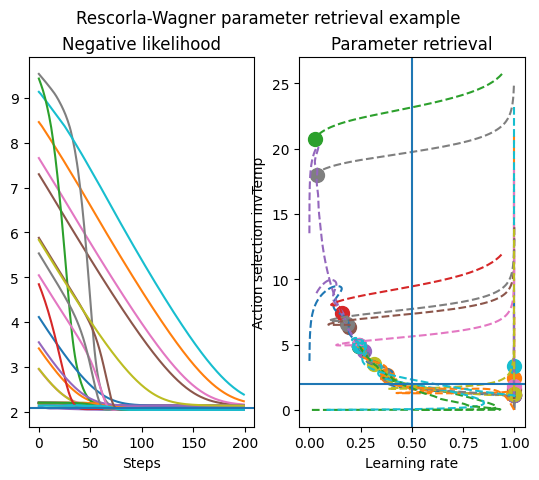

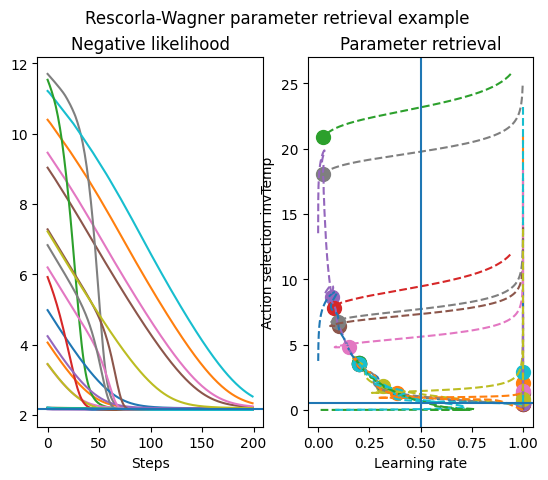

In [7]:
# _________________________________________________________________
# Action selection is quite random :
TRUE_PARAMS = (0.5,2.0)
N_TRIALS = 10

static_params = (9,)
rw_agent = partial(rescorla_wagner_agent,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,rw_agent(TRUE_PARAMS),N_TRIALS,10)

# Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,rw_agent,2,jr.PRNGKey(5),true_hyperparams=TRUE_PARAMS,                          
                                                        num_steps=200,n_iter=30,initial_window=[-10,30])

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,2)
axs[0].set_title("Negative likelihood")
axs[0].set_xlabel("Steps")
axs[1].set_title("Parameter retrieval")
axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Action selection invTemp")
fig.suptitle("Rescorla-Wagner parameter retrieval example")
for i,vec in enumerate(opt_vectors):
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses)
    
    # print(encoding_function(vec),loss_history[-1,i])
    lrs,action_selection_temp = vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(lrs,action_selection_temp,linestyle="--")
    axs[1].scatter(lrs[-1],action_selection_temp[-1],s=100)

# Plot true values :
axs[0].axhline(gt_mle)
axs[1].axvline(TRUE_PARAMS[0])
axs[1].axhline(TRUE_PARAMS[1])

# _________________________________________________________________
# Selection is very random :
TRUE_PARAMS = (0.5,0.5)
N_TRIALS = 10

static_params = (9,)
rw_agent = partial(rescorla_wagner_agent,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,rw_agent(TRUE_PARAMS),N_TRIALS,10)

# Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,rw_agent,2,jr.PRNGKey(5),true_hyperparams=TRUE_PARAMS,                          
                                                        num_steps=200,n_iter=30,initial_window=[-10,30])

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,2)
axs[0].set_title("Negative likelihood")
axs[0].set_xlabel("Steps")
axs[1].set_title("Parameter retrieval")
axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Action selection invTemp")
fig.suptitle("Rescorla-Wagner parameter retrieval example")
for i,vec in enumerate(opt_vectors):
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses)
    
    # print(encoding_function(vec),loss_history[-1,i])
    lrs,action_selection_temp = vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(lrs,action_selection_temp,linestyle="--")
    axs[1].scatter(lrs[-1],action_selection_temp[-1],s=100)

# Plot true values :
axs[0].axhline(gt_mle)
axs[1].axvline(TRUE_PARAMS[0])
axs[1].axhline(TRUE_PARAMS[1])

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
[[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.

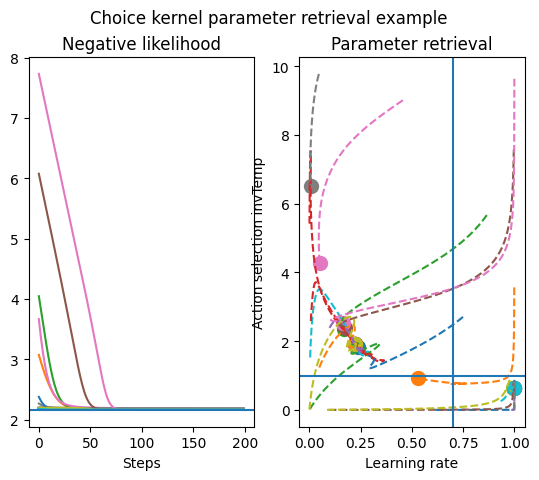

In [4]:

TRUE_PARAMS = (0.7,1.0)
N_TRIALS = 10

static_params = (9,)
ck_agent = partial(choice_kernel_agent,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,ck_agent(TRUE_PARAMS),N_TRIALS,10)

(_,_,_,actions,_) = DATA
print(actions)

# Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,ck_agent,2,jr.PRNGKey(0),true_hyperparams=TRUE_PARAMS,
                                                                                  num_steps=200,n_iter=20)

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,2)
axs[0].set_title("Negative likelihood")
axs[0].set_xlabel("Steps")
axs[1].set_title("Parameter retrieval")
axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Action selection invTemp")
fig.suptitle("Choice kernel parameter retrieval example")
for i,vec in enumerate(opt_vectors):
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses)
    
    # print(encoding_function(vec),loss_history[-1,i])
    lrs,action_selection_temp = vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(lrs,action_selection_temp,linestyle="--")
    axs[1].scatter(lrs[-1],action_selection_temp[-1],s=100)
# Plot true values :
axs[0].axhline(gt_mle)
axs[1].axvline(TRUE_PARAMS[0])
axs[1].axhline(TRUE_PARAMS[1])

Ouch ! The choice kernel model parameters seem hard to retrieve here ... This is probably because in most situations, this model converges pretty quickly. As such, there are many explanations for the same training curve.

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


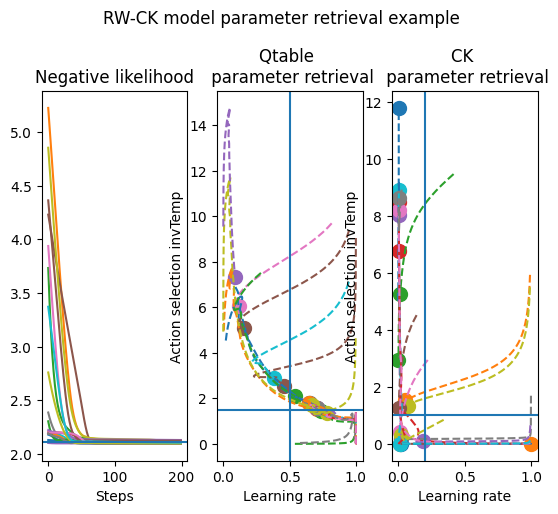

In [5]:

TRUE_PARAMS = (0.5,1.5,0.2,1.0)
N_TRIALS = 10

static_params = (9,)
_rw_ck_agent = partial(rw_ck_agent,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,_rw_ck_agent(TRUE_PARAMS),N_TRIALS,0)

# Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,_rw_ck_agent,len(TRUE_PARAMS),jr.PRNGKey(0),true_hyperparams=TRUE_PARAMS,
                                                                                  num_steps=200,n_iter=20)

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,3)
axs[0].set_title("Negative likelihood")
axs[0].set_xlabel("Steps")

axs[1].set_title("Qtable \n parameter retrieval")
axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Action selection invTemp")

axs[2].set_title("CK \n parameter retrieval")
axs[2].set_xlabel("Learning rate")
axs[2].set_ylabel("Action selection invTemp")
fig.suptitle("RW-CK model parameter retrieval example",y=1.05)
for i,vec in enumerate(opt_vectors):
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses)
    
    # print(encoding_function(vec),loss_history[-1,i])
    lr_qt,beta_qt,lr_ck,beta_ck = vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(lr_qt,beta_qt,linestyle="--")
    axs[1].scatter(lr_qt[-1],beta_qt[-1],s=100)
    
    axs[2].plot(lr_ck,beta_ck,linestyle="--")
    axs[2].scatter(lr_ck[-1],beta_ck[-1],s=100)

# Plot true values :
axs[0].axhline(gt_mle)
axs[1].axvline(TRUE_PARAMS[0])
axs[1].axhline(TRUE_PARAMS[1])

axs[2].axvline(TRUE_PARAMS[2])
axs[2].axhline(TRUE_PARAMS[3])

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


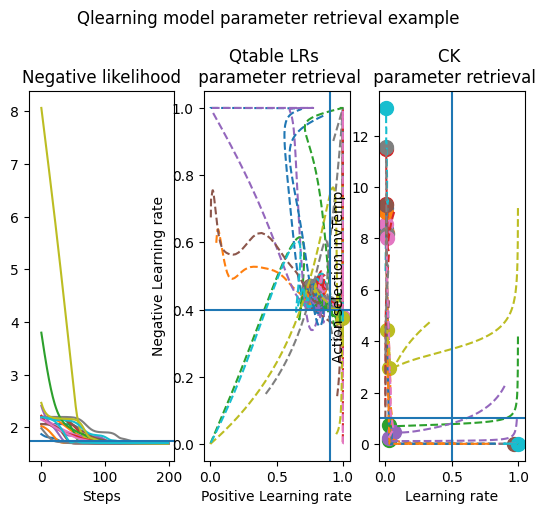

In [6]:
TRUE_PARAMS = (0.9,0.4,10.0, 0.5,1.0)
# alpha-, alpha+, lr, alpha_ck, beta_ck
N_TRIALS = 10

static_params = (9,N_FEEDBACK_OUTCOMES)
_qlearning_agent = partial(q_learning_agent,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,_qlearning_agent(TRUE_PARAMS),N_TRIALS,0)

# Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,_qlearning_agent,len(TRUE_PARAMS),jr.PRNGKey(0),true_hyperparams=TRUE_PARAMS,
                                                                                  num_steps=200,n_iter=20)

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,3)
axs[0].set_title("Negative likelihood")

axs[0].set_xlabel("Steps")

axs[1].set_title("Qtable LRs \n parameter retrieval")
axs[1].set_xlabel("Positive Learning rate")
axs[1].set_ylabel("Negative Learning rate")

# axs[1].set_title("Qtable LRs \n parameter evolution")
# axs[1].set_xlabel("Positive Learning rate")
# axs[1].set_ylabel("Negative Learning rate")

axs[2].set_title("CK \n parameter retrieval")
axs[2].set_xlabel("Learning rate")
axs[2].set_ylabel("Action selection invTemp")
fig.suptitle("Qlearning model parameter retrieval example",y=1.05)
for i,vec in enumerate(opt_vectors):
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses)
    
    # print(encoding_function(vec),loss_history[-1,i])
    alpha_minus,alpha_plus,beta,lr_ck,beta_ck = vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(alpha_minus,alpha_plus,linestyle="--")
    axs[1].scatter(alpha_minus[-1],alpha_plus[-1],s=100)
    
    axs[2].plot(lr_ck,beta_ck,linestyle="--")
    axs[2].scatter(lr_ck[-1],beta_ck[-1],s=100)

# Plot true values :
axs[0].axhline(gt_mle)
axs[0].set_xlim(left=-20.0)
axs[1].axvline(TRUE_PARAMS[0])
axs[1].axhline(TRUE_PARAMS[1])

axs[2].axvline(TRUE_PARAMS[3])
axs[2].axhline(TRUE_PARAMS[4])

In [7]:
N_TRIALS = 10


# We get a model weights by defining a "parameters" object :
static_params = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions" :9,
    
    "Th" : 2,
    
    "learn_e": True
}

TRUE_PARAMS = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 1.0,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" : 10.0,
    "habits_learning_rate" : 0.3,
    
    "action_selection_temperature" : 10.0,
}
N_hyperparams = len(TRUE_PARAMS)

_aif_1d_agent = partial(active_inference_basic_1D,constants=static_params)
DATA = generate_synthetic_data(ENVIRONMENT,_aif_1d_agent(TRUE_PARAMS),N_TRIALS,0)

# # Multi-iteration based MLE : (we randomize the initial point and try to fall back on our feet :D )
opt_vectors,(gt_mle,loss_history,param_history),encoding_function = fit_mle_agent(DATA,_aif_1d_agent,N_hyperparams,jr.PRNGKey(10),true_hyperparams=TRUE_PARAMS,
                                                                                  num_steps=250,n_iter=20)


Trial 0
(10,)
(10, 5)
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)


In [8]:
print("__________________________________________________________________________")
print("Final log likelihoods :")
print( - loss_history[-1])
print("Log likelihood for the true causing parameters :")
print( - gt_mle)
print("__________________________________________________________________________")

__________________________________________________________________________
Final log likelihoods :
[-1.5177873 -2.1972234 -1.6167256 -1.1863542 -2.1972232 -1.5171515
 -2.1972232 -1.5212704 -1.5152111 -1.1860465 -2.1972232 -1.1899304
 -1.5653214 -2.1972232 -1.6361291 -2.1972232 -1.1885686 -1.6578132
 -2.1972232 -2.1972232]
Log likelihood for the true causing parameters :
-1.2550757
__________________________________________________________________________


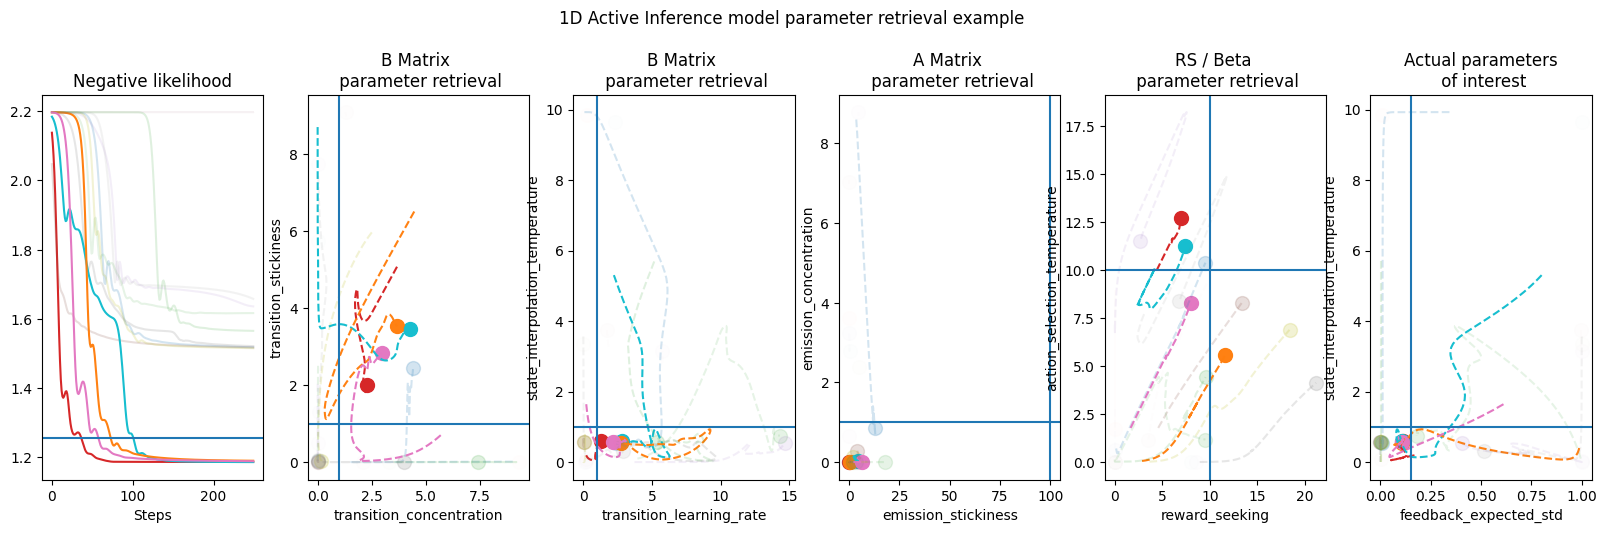

In [9]:

best_candidates = (jax.nn.softmax(- 5*loss_history[-1]))
best_candidates = best_candidates/jnp.max(best_candidates)

# Parameter retrieval plot for this specific set of true values
fig,axs = plt.subplots(1,6,figsize=(20,5))
axs[0].set_title("Negative likelihood")
axs[0].set_xlabel("Steps")

axs[1].set_title("B Matrix \n parameter retrieval")
axs[1].set_xlabel("transition_concentration")
axs[1].set_ylabel("transition_stickiness")

axs[2].set_title("B Matrix \n parameter retrieval")
axs[2].set_xlabel("transition_learning_rate")
axs[2].set_ylabel("state_interpolation_temperature")

axs[3].set_title("A Matrix \n parameter retrieval")
axs[3].set_xlabel("emission_stickiness")
axs[3].set_ylabel("emission_concentration")

axs[4].set_title("RS / Beta \n parameter retrieval")
axs[4].set_xlabel("reward_seeking")
axs[4].set_ylabel("action_selection_temperature")

axs[5].set_title("Actual parameters\n of interest")
axs[5].set_xlabel("feedback_expected_std")
axs[5].set_ylabel("state_interpolation_temperature")

fig.suptitle("1D Active Inference model parameter retrieval example",y=1.05)
for i,vec in enumerate(opt_vectors):
    weight_iteration = float(best_candidates[i])
    
    losses = loss_history[:,i]
    steps = jnp.arange(losses.shape[0])
    axs[0].plot(steps,losses,alpha=weight_iteration)
    
    # print(encoding_function(vec),loss_history[-1,i])
    encoded_dictionnary= vmap(lambda x : encoding_function(x))(param_history[i,...])
    axs[1].plot(encoded_dictionnary["transition_concentration"],encoded_dictionnary["transition_stickiness"],linestyle="--",alpha=weight_iteration)
    axs[1].scatter(encoded_dictionnary["transition_concentration"][-1],encoded_dictionnary["transition_stickiness"][-1],s=100,alpha=weight_iteration)
    
    axs[2].plot(encoded_dictionnary["transition_learning_rate"],encoded_dictionnary["state_interpolation_temperature"],linestyle="--",alpha=weight_iteration)
    axs[2].scatter(encoded_dictionnary["transition_learning_rate"][-1],encoded_dictionnary["state_interpolation_temperature"][-1],s=100,alpha=weight_iteration)
    
    axs[3].plot(encoded_dictionnary["emission_stickiness"],encoded_dictionnary["emission_concentration"],linestyle="--",alpha=weight_iteration)
    axs[3].scatter(encoded_dictionnary["emission_stickiness"][-1],encoded_dictionnary["emission_concentration"][-1],s=100,alpha=weight_iteration)
    
    axs[4].plot(encoded_dictionnary["reward_seeking"],encoded_dictionnary["action_selection_temperature"],linestyle="--",alpha=weight_iteration)
    axs[4].scatter(encoded_dictionnary["reward_seeking"][-1],encoded_dictionnary["action_selection_temperature"][-1],s=100,alpha=weight_iteration)

    axs[5].plot(encoded_dictionnary["feedback_expected_std"],encoded_dictionnary["state_interpolation_temperature"],linestyle="--",alpha=weight_iteration)
    axs[5].scatter(encoded_dictionnary["feedback_expected_std"][-1],encoded_dictionnary["state_interpolation_temperature"][-1],s=100,alpha=weight_iteration)
    
# Plot true values :
axs[0].axhline(gt_mle)

axs[1].axvline(TRUE_PARAMS["transition_concentration"])
axs[1].axhline(TRUE_PARAMS["transition_stickiness"])

axs[2].axvline(TRUE_PARAMS["transition_learning_rate"])
axs[2].axhline(TRUE_PARAMS["state_interpolation_temperature"])

axs[3].axvline(TRUE_PARAMS["emission_stickiness"])
axs[3].axhline(TRUE_PARAMS["emission_concentration"])

axs[4].axvline(TRUE_PARAMS["reward_seeking"])
axs[4].axhline(TRUE_PARAMS["action_selection_temperature"])

axs[5].axvline(TRUE_PARAMS["feedback_expected_std"])
axs[5].axhline(TRUE_PARAMS["state_interpolation_temperature"])


Encouraging results ! However, let's note a few things regarding the  inversion : 
- the inversion is pretty slow, hinting that further optimization or other fitting methods (Simulation based Inference ?) would be required for more complex AIF models
- The fitted parameters are often correlated : we need a way to restrain the parameter space to focus on a more specific solution, even if it means assuming that some parameters are more likely *a-priori* than others. For instance, we may assume that reward seeking is probably above 0 for all subjects (they all wanted to increase the level of the gauge). Let's focus on that for now and try to implement an MAP estimate of the parameters, allowing us to encode prior beliefs about the parameters of the subject's to facilitate and disambiguate the inference !